### Quora Question Pairs Task:

### The task of QQP is to say whether two questions are similar

### Importing the required libraries

In [ ]:
import pickle
import torch
import numpy as np
import pandas as pd
from datasets import load_dataset
from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

### Checking if gpu is available

In [1]:
import torch

if torch.cuda.is_available():       
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: NVIDIA RTX A4000


### Loading the dataset

In [2]:
from datasets import load_dataset
dataset = load_dataset('glue', 'qqp')
dataset

Found cached dataset glue (C:/Users/NIT/.cache/huggingface/datasets/glue/qqp/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['question1', 'question2', 'label', 'idx'],
        num_rows: 363846
    })
    validation: Dataset({
        features: ['question1', 'question2', 'label', 'idx'],
        num_rows: 40430
    })
    test: Dataset({
        features: ['question1', 'question2', 'label', 'idx'],
        num_rows: 390965
    })
})

### Using the tokenizer from huggingface

In [4]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("gchhablani/bert-base-cased-finetuned-qqp")

### Loading the pre-trained and fine-tuned models from huggingface and moving them to device

In [7]:
preTrainedModel = AutoModelForSequenceClassification.from_pretrained("bert-base-cased",
                                                      num_labels = 2,
                                                      output_attentions = True,
                                                      output_hidden_states = True,)
preTrainedModel.cuda()

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [6]:
from transformers import AutoModelForSequenceClassification
fineTunedModel = AutoModelForSequenceClassification.from_pretrained("gchhablani/bert-base-cased-finetuned-qqp")
fineTunedModel.cuda()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

### Forming dataloaders

In [ ]:
tokenised_dataset = tokenizer(dataset['train']['question1'], dataset['train']['question2'], padding=True, return_tensors='pt')
input_ids = tokenised_dataset['input_ids']
token_type_ids = tokenised_dataset['token_type_ids']
attention_masks = tokenised_dataset['attention_mask']
labels = torch.tensor(dataset['train']['label'])

# Set the batch size.  
batch_size = 16 

# Create the DataLoader.
train_data = TensorDataset(input_ids, token_type_ids, attention_masks, labels)
train_sampler = SequentialSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

In [9]:
tokenised_dataset = tokenizer(dataset['test']['question1'], dataset['test']['question2'], padding=True, return_tensors='pt')
input_ids = tokenised_dataset['input_ids']
token_type_ids = tokenised_dataset['token_type_ids']
attention_masks = tokenised_dataset['attention_mask']
labels = torch.tensor(dataset['test']['label'])

# Set the batch size.  
batch_size = 16 

# Create the DataLoader.
test_data = TensorDataset(input_ids, token_type_ids, attention_masks, labels)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

### Getting CLS hidden states for all layers [13, number of sampes, 768] to check layer-wise accuracy

In [3]:
def getCLSHiddenStates(model, prediction_dataloader):
    model.eval()
    totalHiddenStates = [0]*13
    flag = True
    for batch in prediction_dataloader:
        batch = tuple(t.to(device) for t in batch)
  
        # Unpack the inputs from our dataloader
        b_input_ids, b_token_type_ids, b_input_mask, b_labels = batch
  
        with torch.no_grad():
            result = model(b_input_ids,
                           token_type_ids=b_token_type_ids,
                           attention_mask=b_input_mask,
                           output_hidden_states = True,
                           return_dict=True)
            
        hidden_states = result.hidden_states
        if flag == True:
            for i in range(len(hidden_states)):
                totalHiddenStates[i] = hidden_states[i][:,0,:].to("cpu")
            flag = False
        else:
            for i in range(len(hidden_states)):
                temp = hidden_states[i][:,0,:].to("cpu")
                totalHiddenStates[i] = torch.cat((totalHiddenStates[i], temp), 0)
    return totalHiddenStates     

In [ ]:
train_q1 = dataset['train']['question1']
train_q2 = dataset['train']['question2']
test_q1 = dataset['test']['question1']
test_q1 = dataset['test']['question2']

In [ ]:
num_rows = dataset['train'].num_rows
hiddenStates = [0]*13
flag = True
for i in range(0, num_rows//10000 +1):
    print(i)
    st = i*10000
    if(i==num_rows//10000):
        end = num_rows
    else:
        end = (i+1)*10000
    tokenised_dataset = tokenizer(train_q1[st:end], 
                                  train_q2[st:end], truncation = True, padding=True, return_tensors='pt')
    input_ids = tokenised_dataset['input_ids']
    token_type_ids = tokenised_dataset['token_type_ids']
    attention_masks = tokenised_dataset['attention_mask']
    labels = torch.tensor(dataset['train']['label'][st:end])
  
    
    batch_size = 16 
    train_data = TensorDataset(input_ids, token_type_ids, attention_masks, labels)
    train_sampler = SequentialSampler(train_data)
    train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
    
    hS = getCLSHiddenStates(preTrainedModel, train_dataloader)
    if flag==True:
        for j in range(13):
            hiddenStates[j] = hS[j]
        flag = False
    else:
        for j in range(13):
            hiddenStates[j] = torch.cat((hiddenStates[j], hS[j]), dim = 0)

preTrainedCLSHiddenStatesTrain = torch.stack(hiddenStates, dim = 0)
#torch.save(fineTunedCLSHiddenStatesTrain, 'fineTunedCLSHiddenStatesTrain_qqp.pt')
preTrainedCLSHiddenStatesTrain.shape

In [ ]:
num_rows = dataset['test'].num_rows
hiddenStates = [0]*13
flag = True
for i in range(0, num_rows//10000 +1):
    print(i)
    st = i*10000
    if(i==num_rows//10000):
        end = num_rows
    else:
        end = (i+1)*10000
    tokenised_dataset = tokenizer(test_q1[st:end], 
                                  test_q2[st:end], truncation = True, padding=True, return_tensors='pt')
    input_ids = tokenised_dataset['input_ids']
    token_type_ids = tokenised_dataset['token_type_ids']
    attention_masks = tokenised_dataset['attention_mask']
    labels = torch.tensor(dataset['test']['label'][st:end])
  
    
    batch_size = 16 
    test_data = TensorDataset(input_ids, token_type_ids, attention_masks, labels)
    test_sampler = SequentialSampler(test_data)
    test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)
    
    hS = getCLSHiddenStates(preTrainedModel, test_dataloader)
    if flag==True:
        for j in range(13):
            hiddenStates[j] = hS[j]
        flag = False
    else:
        for j in range(13):
            hiddenStates[j] = torch.cat((hiddenStates[j], hS[j]), dim = 0)

preTrainedCLSHiddenStatesTest= torch.stack(hiddenStates, dim = 0)
#torch.save(preTrainedCLSHiddenStatesTest, 'preTrainedCLSHiddenStatesTest_qqp.pt')
preTrainedCLSHiddenStatesTest.shape

In [ ]:
num_rows = dataset['train'].num_rows
hiddenStates = [0]*13
flag = True
for i in range(0, num_rows//10000 +1):
    print(i)
    st = i*10000
    if(i==num_rows//10000):
        end = num_rows
    else:
        end = (i+1)*10000
    tokenised_dataset = tokenizer(train_q1[st:end], 
                                  train_q2[st:end], truncation = True,padding=True, return_tensors='pt')
    input_ids = tokenised_dataset['input_ids']
    token_type_ids = tokenised_dataset['token_type_ids']
    attention_masks = tokenised_dataset['attention_mask']
    labels = torch.tensor(dataset['train']['label'][st:end])
  
    
    batch_size = 16 
    train_data = TensorDataset(input_ids, token_type_ids, attention_masks, labels)
    train_sampler = SequentialSampler(train_data)
    train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
    
    hS = getCLSHiddenStates(fineTunedModel, train_dataloader)
    if flag==True:
        for j in range(13):
            hiddenStates[j] = hS[j]
        flag = False
    else:
        for j in range(13):
            hiddenStates[j] = torch.cat((hiddenStates[j], hS[j]), dim = 0)

fineTunedCLSHiddenStatesTrain = torch.stack(hiddenStates, dim = 0)
#torch.save(fineTunedCLSHiddenStatesTrain, 'fineTunedCLSHiddenStatesTrain_qqp.pt')
fineTunedCLSHiddenStatesTrain.shape

In [ ]:
num_rows = dataset['test'].num_rows
hiddenStates = [0]*13
flag = True
for i in range(0, num_rows//10000 +1):
    print(i)
    st = i*10000
    if(i==num_rows//10000):
        end = num_rows
    else:
        end = (i+1)*10000
    tokenised_dataset = tokenizer(test_q1[st:end], 
                                  test_q2[st:end], truncation = True, padding=True, return_tensors='pt')
    input_ids = tokenised_dataset['input_ids']
    token_type_ids = tokenised_dataset['token_type_ids']
    attention_masks = tokenised_dataset['attention_mask']
    labels = torch.tensor(dataset['test']['label'][st:end])
  
    
    batch_size = 16 
    test_data = TensorDataset(input_ids, token_type_ids, attention_masks, labels)
    test_sampler = SequentialSampler(test_data)
    test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)
    
    hS = getCLSHiddenStates(fineTunedModel, test_dataloader)
    if flag==True:
        for j in range(13):
            hiddenStates[j] = hS[j]
        flag = False
    else:
        for j in range(13):
            hiddenStates[j] = torch.cat((hiddenStates[j], hS[j]), dim = 0)
fineTunedCLSHiddenStatesTest= torch.stack(hiddenStates, dim = 0)
#torch.save(preTrainedCLSHiddenStatesTest, 'preTrainedCLSHiddenStatesTest_qqp.pt')
fineTunedCLSHiddenStatesTest.shape

In [15]:
num_rows = dataset['test'].num_rows
flag = True
for i in range(0, num_rows//10000 +1):
    print(i)
    st = i*10000
    if(i==num_rows//10000):
        end = num_rows
    else:
        end = (i+1)*10000
    tokenised_dataset = tokenizer(test_q1[st:end], 
                                  test_q2[st:end], truncation = True, padding=True, return_tensors='pt')
    input_ids = tokenised_dataset['input_ids']
    token_type_ids = tokenised_dataset['token_type_ids']
    attention_masks = tokenised_dataset['attention_mask']
    labels = torch.tensor(dataset['test']['label'][st:end])
  
    
    batch_size = 16 
    test_data = TensorDataset(input_ids, token_type_ids, attention_masks, labels)
    test_sampler = SequentialSampler(test_data)
    test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)
    
    hS = getCLSHiddenStates(fineTunedModel, test_dataloader)
    if flag==True:
        #for j in range(13):
        hiddenStates = hS
        flag = False
    else:
        #for j in range(13):
        hiddenStates = torch.cat((hiddenStates, hS), dim = 0)
fineTunedCLSHiddenStatesTest= hiddenStates
#torch.save(preTrainedCLSHiddenStatesTest, 'preTrainedCLSHiddenStatesTest_qqp.pt')
fineTunedCLSHiddenStatesTest.shape

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39


torch.Size([390965, 768])

In [10]:
def getLabels(model, data_loader):
    predictions = []
    for batch in data_loader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_token_type_ids, b_input_mask, b_labels = batch
  
        with torch.no_grad():
            results = model(b_input_ids, token_type_ids=b_token_type_ids, attention_mask=b_input_mask, return_dict=True)
            logits = results.logits
            pred = torch.argmax(logits, dim = 1)
            predictions.extend(pred.tolist())
    return predictions

In [ ]:
import numpy as np
import pandas as pd
predictions = getLabels(fineTunedModel, test_dataloader)

In [12]:
filename = 'QQP.tsv'
result = pd.DataFrame(predictions, columns=['prediction'])
result.insert(0, 'index', range(0, len(result)))
result.to_csv(filename, sep='\t', index=False)

### Forming logistic regressions at each layer to find the layer-wise accuracy for pre-trained and fine-tuned model

In [13]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression    
sc_x = StandardScaler()
for i in range(13):
    xtrain = sc_x.fit_transform(preTrainedCLSHiddenStatesTrain[i])
    xtest = sc_x.fit_transform(preTrainedCLSHiddenStatesTest[i])
    logreg = LogisticRegression(max_iter=1000)
    logreg.fit(xtrain, dataset['train']['label']) 
    
    preTrain_pred=logreg.predict(xtest)
    filename = 'p{0}/QQP.tsv'.format(i)
    result = pd.DataFrame(preTrain_pred, columns=['prediction'])
    result.insert(0, 'index', range(0, len(result)))
    result.to_csv(filename, sep='\t', index=False)
    
    
    xtrain = sc_x.fit_transform(fineTunedCLSHiddenStatesTrain[i]) 
    xtest = sc_x.fit_transform(fineTunedCLSHiddenStatesTest[i])
    logreg = LogisticRegression(max_iter=1000)
    logreg.fit(xtrain, dataset['train']['label'])
    
    fineTuned_pred=logreg.predict(xtest)
    filename = 'f{0}/QQP.tsv'.format(i)
    result = pd.DataFrame(fineTuned_pred, columns=['prediction'])
    result.insert(0, 'index', range(0, len(result)))
    result.to_csv(filename, sep='\t', index=False)

/home/user/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regressi

### Finding the accuracy of the final layer using the classifier of the fine-tuned model

In [14]:
params = list(fineTunedModel.named_parameters())
dense = torch.nn.Linear(768, 768,device=device, bias = True)
activation = torch.nn.Tanh()
dropout = torch.nn.Dropout(p=0.1)
classifier = torch.nn.Linear(in_features=768, out_features=2,  bias = True)
with torch.no_grad():
    dense.weight = params[-4][1]
    dense.bias = params[-3][1]
    classifier.weight = params[-2][1]
    classifier.bias = params[-1][1]

pooled_output = activation(dense(fineTunedCLSHiddenStatesTest[-1].to('cuda:0')))
dropout_op = dropout(pooled_output)
logits = classifier(dropout_op)
predictions = torch.argmax(logits, dim = 1)

In [15]:
import pandas as pd
predictions = predictions.to('cpu')
filename ='QQP.tsv'
result = pd.DataFrame(predictions, columns=['prediction'])
result.insert(0, 'index', range(0, len(result)))
result.to_csv(filename, sep='\t', index=False)

### Obtaining hidden states to find the CKA metric between the pre-trained and fine-tuned model on test dataset

In [16]:
testDataset = dataset['test'].shuffle(seed=42)

Loading cached shuffled indices for dataset at /home/user/.cache/huggingface/datasets/glue/qqp/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad/cache-0aa7078f1b4799e3.arrow


In [23]:
test_q1 = [sentence.split(" ", 1)[1] if " " in sentence else sentence for sentence in testDataset['question1'][:20000]]
test_q2 = [sentence.split(" ", 1)[1] if " " in sentence else sentence for sentence in testDataset['question2'][:20000]]

In [42]:
test_q1 = [sentence.rsplit(" ", 1)[0] + sentence[-1] for sentence in testDataset['question1'][:20000]]
test_q2 = [sentence.rsplit(" ", 1)[0] + sentence[-1] for sentence in testDataset['question2'][:20000]]

In [28]:
no_nouns_test_q1sentences = []
no_verbs_test_q1sentences = []

for sentence in testDataset['question1'][:20000]:
    no_nouns_test_q1sentences.append(remove_nouns(sentence))
    no_verbs_test_q1sentences.append(remove_verbs(sentence))

no_nouns_test_q2sentences = []
no_verbs_test_q2sentences = []

for sentence in testDataset['question2'][:20000]:
    no_nouns_test_q2sentences.append(remove_nouns(sentence))
    no_verbs_test_q2sentences.append(remove_verbs(sentence))

In [21]:
test_q1 = [random_swap_words(sentence) for sentence in testDataset['question1'][:20000]]
test_q2 = [random_swap_words(sentence) for sentence in testDataset['question2'][:20000]]

In [11]:
test_q1 = add_random_words(testDataset['question1'][:20000])
test_q2 = add_random_words(testDataset['question2'][:20000])

In [20]:
test_q1 = [replace_characters(sentence) for sentence in testDataset['question1'][:20000]]
test_q2 = [replace_characters(sentence) for sentence in testDataset['question2'][:20000]]

In [17]:
test_q1 = [changeGender(sentence) for sentence in testDataset['question1'][:20000]]
test_q2 = [changeGender(sentence) for sentence in testDataset['question2'][:20000]]

In [18]:
tokenised_dataset = tokenizer(test_q1, test_q2, padding=True, truncation = True, return_tensors='pt')
input_ids = tokenised_dataset['input_ids']
token_type_ids = tokenised_dataset['token_type_ids']
attention_masks = tokenised_dataset['attention_mask']
labels = torch.tensor(testDataset['label'][:20000])

# Set the batch size.  
batch_size = 16 

# Create the DataLoader.
test_data = TensorDataset(input_ids, token_type_ids, attention_masks, labels)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

In [19]:
def getHiddenStates(model, prediction_dataloader):
    model.eval()
    totalHiddenStates = [0]*13
    flag = True
    for batch in prediction_dataloader:
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
  
        # Unpack the inputs from our dataloader
        b_input_ids, b_token_type_ids, b_input_mask, b_labels = batch
  
        with torch.no_grad():
            result = model(b_input_ids,
                           token_type_ids=b_token_type_ids,
                           attention_mask=b_input_mask,
                           output_hidden_states = True,
                           return_dict=True)
            
        hidden_states = result.hidden_states
        if flag == True:
            for i in range(len(hidden_states)):
                totalHiddenStates[i] = hidden_states[i].to("cpu").mean(dim = 1)
            flag = False
        else:
            for i in range(len(hidden_states)):
                temp = hidden_states[i].to("cpu").mean(dim = 1)
                totalHiddenStates[i] = torch.cat((totalHiddenStates[i], temp), 0)   
    return totalHiddenStates     

In [20]:
hiddenStates = getHiddenStates(preTrainedModel, test_dataloader)
preTrainedHiddenStates = torch.stack(hiddenStates, dim = 0)
#torch.save(preTrainedHiddenStates, 'preTrainedHiddenStates_qqp.pt')
preTrainedHiddenStates.shape

torch.Size([13, 20000, 768])

In [21]:
hiddenStates = getHiddenStates(fineTunedModel, test_dataloader)
fineTunedHiddenStates = torch.stack(hiddenStates, dim = 0)
#torch.save(fineTunedHiddenStates, 'fineTunedHiddenStates_qqp.pt')
fineTunedHiddenStates.shape

torch.Size([13, 20000, 768])

In [22]:
from CKA import CKA, CudaCKA
cuda_cka = CudaCKA(device)

In [23]:
cka_matrix = torch.empty((13, 13))
for i in range(13):
    for j in range(13):
        X = preTrainedHiddenStates[i].to(device)
        Y = fineTunedHiddenStates[j].to(device)
        cka_matrix[i][j] = cuda_cka.linear_CKA(X, Y)
#torch.save(cka_matrix, 'qqp-ckaMatrix.pt')
cka_matrix = cka_matrix.numpy()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(cka_matrix, cmap="inferno", vmin=0.0, vmax=1.0)

plt.xticks(np.arange(0,13), fontsize = 14)
plt.yticks(np.arange(0,13), fontsize = 14)

cka_matrix = np.round(cka_matrix, 2)
for x in range(13):
    for y in range(13):
        plt.annotate(str(cka_matrix[x][y]), xy=(y, x), horizontalalignment='center', verticalalignment='center', fontsize=13)

plt.ylabel('Pre-trained BERT', fontsize = 17)
plt.xlabel('Fine-tuned BERT', fontsize = 17)

#fig.colorbar(im)

plt.tight_layout()

#plt.show()

plt.savefig('QQP_preTrained_fineTuned.pdf',  bbox_inches='tight')
plt.savefig('QQP_preTrained_fineTuned.jpg',  bbox_inches='tight')

### STIR

In [3]:
preTrainedHiddenStates = torch.load('./preTrainedHiddenStates_qqp.pt').to(device)
fineTunedHiddenStates  = torch.load('./fineTunedHiddenStates_qqp.pt').to(device)
print(preTrainedHiddenStates.shape,fineTunedHiddenStates.shape)

torch.Size([13, 10000, 768]) torch.Size([13, 10000, 768])


In [4]:
distinm1 = []
distinm2 = []
for i in range(13):
    distinm1.append(torch.cdist(preTrainedHiddenStates[i], preTrainedHiddenStates[i]))
    distinm2.append(torch.cdist(fineTunedHiddenStates[i], fineTunedHiddenStates[i]))

In [5]:
for i in range(13):
    for j in range(distinm1[0].shape[0]):
        distinm1[i][j][j] = 100000.0
        distinm2[i][j][j] = 100000.0

In [7]:
num_rows = preTrainedHiddenStates.shape[1]
minDistIndForm1 = []
for i in range(13):
    temp = []
    for j in range(num_rows):
        temp.append(torch.argmin(distinm1[i][j]))
    minDistIndForm1.append(temp)
    
minDistIndForm2 = []
for i in range(13):
    temp = []
    for j in range(num_rows):
        temp.append(torch.argmin(distinm2[i][j]))
    minDistIndForm2.append(temp)

In [8]:
from CKA import CKA, CudaCKA
cuda_cka = CudaCKA(device)

In [9]:
import random
def calculate(noOfSamples, noOfTimes):
    STIRm2m1 = []
    STIRm1m2 = []
    CKA = []
    for i in range(13):
        stirm2m1 = 0
        stirm1m2 = 0
        cka = 0
        for j in range(noOfTimes):
            num_list = random.sample(range(0, num_rows), noOfSamples)
            X = []
            X_ = []
            Y = []
            Y_ = []
            for k in range(len(num_list)):
                X.append(fineTunedHiddenStates[i][num_list[k]])
                X_.append(fineTunedHiddenStates[i][minDistIndForm1[i][num_list[k]]])
                Y.append(preTrainedHiddenStates[i][num_list[k]])
                Y_.append(preTrainedHiddenStates[i][minDistIndForm2[i][num_list[k]]])
                
            X = torch.stack(X, dim = 0)
            X_ = torch.stack(X_, dim = 0)
            Y = torch.stack(Y, dim = 0)
            Y_ = torch.stack(Y_, dim = 0)
            
            stirm2m1 = stirm2m1 + cuda_cka.linear_CKA(X, X_)
            stirm1m2 = stirm1m2 + cuda_cka.linear_CKA(Y, Y_)
            cka = cka + cuda_cka.linear_CKA(Y, X)
        
        STIRm2m1.append(stirm2m1/noOfTimes)
        STIRm1m2.append(stirm1m2/noOfTimes)
        CKA.append(cka/noOfTimes)
    return STIRm2m1, STIRm1m2, CKA

In [10]:
STIRm2m1, STIRm1m2, CKA = calculate(num_rows//2, 20)

In [11]:
STIRm2m1 = torch.stack(STIRm2m1, dim = 0)
STIRm1m2 = torch.stack(STIRm1m2,dim = 0)
CKA = torch.stack(CKA, dim = 0)

In [12]:
STIRm2m1 = STIRm2m1.to("cpu")
STIRm2m1 = STIRm2m1.numpy()
STIRm1m2 = STIRm1m2.to("cpu")
STIRm1m2 = STIRm1m2.numpy()
CKA = CKA .to("cpu")
CKA = CKA .numpy()

In [13]:
print('STIRm2m1:', STIRm2m1)
print('STIRm1m2:', STIRm1m2)
print('CKA:', CKA)

STIRm2m1: [0.9863593  0.86195815 0.8577215  0.77524024 0.74067825 0.70093185
 0.6702987  0.64179873 0.60448325 0.5803028  0.54968685 0.4469897
 0.20524171]
STIRm1m2: [0.9863081  0.87176085 0.87963736 0.78223807 0.7445559  0.7044139
 0.6761998  0.6619066  0.6391497  0.61603117 0.59550714 0.5664785
 0.4285942 ]
CKA: [0.99999046 0.97349405 0.94387645 0.9188718  0.8693833  0.8349892
 0.81361246 0.7919545  0.75630933 0.7105925  0.6660838  0.5272754
 0.10942813]


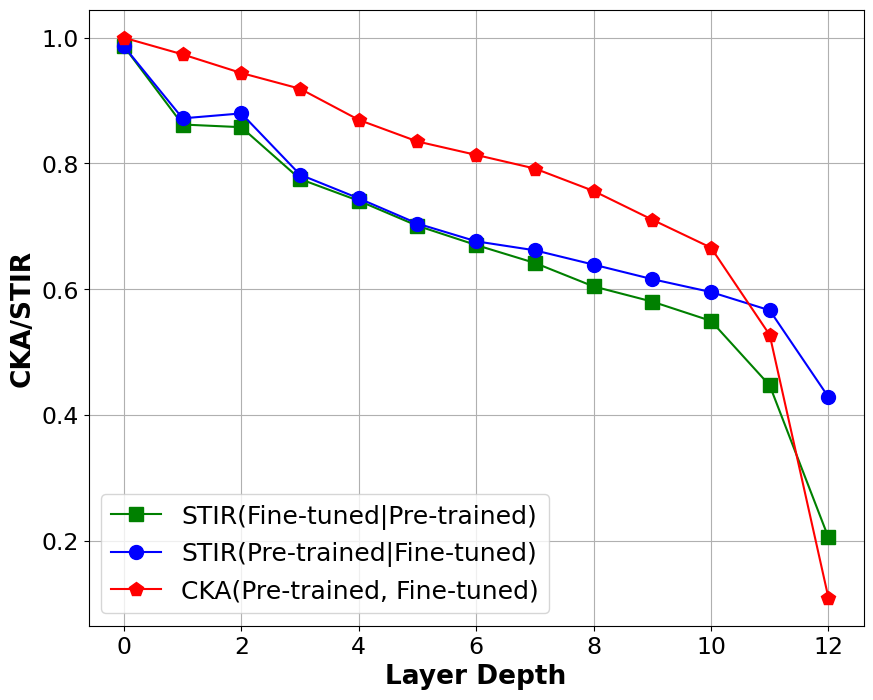

In [2]:
import numpy as np
import matplotlib.pyplot as plt

xs = np.arange(13)
plt.rcParams["figure.figsize"] = [10,8]

series = np.array(STIRm2m1)
smask = np.isfinite(series)
plt.plot(xs[smask], series[smask], linestyle='-', marker='s', markersize=10, color='green')

series = np.array(STIRm1m2)
smask = np.isfinite(series)
plt.plot(xs[smask], series[smask], linestyle='-', marker='o', markersize=10, color='blue')

series = np.array(CKA)
smask = np.isfinite(series)
plt.plot(xs[smask], series[smask], linestyle='-', marker='p', markersize=10, color='red')

plt.legend(['STIR(Fine-tuned|Pre-trained)', 'STIR(Pre-trained|Fine-tuned)', 'CKA(Pre-trained, Fine-tuned)'], fontsize=18)
plt.xlabel('Layer Depth', fontsize = 19, fontweight = 'bold')
plt.ylabel('CKA/STIR', fontsize = 19, fontweight ='bold')

plt.grid(True)
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
#plt.tight_layout()
#plt.show()
plt.savefig('QQP STIR.pdf', bbox_inches='tight')
plt.savefig('QQP STIR.jpg', bbox_inches='tight')